# IMAGE CAPTIONING
- GENERATE CAPTIONS FOR IMAGES

### STEPS:
- Data Collection
- Understanding Data
- Data Cleaning
- Data preprocessing : Images
- Data preprocessing : Text
- Data preperation from Generator Function
- Word Embedding
- Model Architecture
- Inference
- Evaluation

### DataSet used is Flickr 8k  dataset present in Kaggle
- it has:
- 6000 train 
- 1000 val
- 1000 test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
# Read Text Captions

def ReadTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [3]:
captions=ReadTextFile("./flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split("\n")[:-1]

In [4]:
print(captions[0])
print(len(captions))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
40460


In [5]:
# We wil Make a dictionary with the list of captions we have

In [6]:
descriptions={}

for x in captions:
    first,second=x.split("\t")
    img_name=first.split(".")[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    
    descriptions[img_name].append(second)
    

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

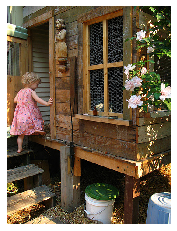

In [8]:
IMG_PATH="./flickr8k/Flickr_Data/Flickr_Data/Images/"
img=cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### DATA CLEANING
- Here we don't need to have lemmatize or stopword removal or stemming because we need proper english.for this we need to train our models without doing such cleaning. we only change to lower ,remove punctuations 

In [9]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is sitting in the door! Help him ")

'cat is sitting in the door help him'

In [11]:
# clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [12]:
# cleaned CAption
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# write the data to another file
with open("description_1.txt","w") as f:
    f.write(str(descriptions))

## VOCABULARY
- SET OF ALL UNIQUE WORDS MODEL CAN PREDICT

In [14]:
descriptions=None
with open("description_1.txt","r") as f:
    descriptions=f.read()
    
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [15]:
# vocab building
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("vocab_size : ",len(vocab))

vocab_size :  8424


In [16]:
# total no.of words across all sentences
total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total words %d"%len(total_words))

Total words 373837


In [17]:
# Filter words from the vocab according to threshold frequency

In [18]:
import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [19]:
# sort this dictionary according to frequency count
sorted_freq_count=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_count]

In [20]:
len(total_words)

1845

# prepare Train/Test data

In [21]:
train_file_data=ReadTextFile("./flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")

In [22]:
test_file_data=ReadTextFile("./flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [23]:
train=[row.split('.')[0] for row in train_file_data.split("\n")[:-1]]
test=[row.split('.')[0] for row in test_file_data.split("\n")[:-1]]

In [24]:
print(len(train))
print(len(test))

6000
1000


In [25]:
# prepare description for Training Data
# Tweak : Add <s> and <e> training to our training data

train_description={}

for img_id in train:
    train_description[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq "+cap+" endseq"
        train_description[img_id].append(cap_to_append)


In [26]:
train_description["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images - Features
- Text - Features

## Step1 : Image Feature Extraction

In [27]:
model=ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [28]:
new_model=Model(model.input,model.layers[-2].output)

In [29]:
def preprocess_image(img):
    img=image.load_img(img,target_size=(224,224,3))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    # normalization
    img=preprocess_input(img)
    return img

In [30]:
#img=preprocess_image(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.show()

In [31]:
def encode_image(img):
    img=preprocess_image(img)
    feature_vector=new_model.predict(img)
    feature_vector=feature_vector.reshape((2048,))
    return feature_vector

In [32]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154469, 0.17075907, 0.29276803, ..., 0.05094024, 0.3131962 ,
       0.8600729 ], dtype=float32)

In [33]:
"""encoding_train={}

for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if (ix%100)==0:
        print("Encoding in progress : timestep :",ix ) """# saved in encoding_train

Encoding in progress : timestep : 0
Encoding in progress : timestep : 100
Encoding in progress : timestep : 200
Encoding in progress : timestep : 300
Encoding in progress : timestep : 400
Encoding in progress : timestep : 500
Encoding in progress : timestep : 600
Encoding in progress : timestep : 700
Encoding in progress : timestep : 800
Encoding in progress : timestep : 900
Encoding in progress : timestep : 1000
Encoding in progress : timestep : 1100
Encoding in progress : timestep : 1200
Encoding in progress : timestep : 1300
Encoding in progress : timestep : 1400
Encoding in progress : timestep : 1500
Encoding in progress : timestep : 1600
Encoding in progress : timestep : 1700
Encoding in progress : timestep : 1800
Encoding in progress : timestep : 1900
Encoding in progress : timestep : 2000
Encoding in progress : timestep : 2100
Encoding in progress : timestep : 2200
Encoding in progress : timestep : 2300
Encoding in progress : timestep : 2400
Encoding in progress : timestep : 250

In [35]:
# write the data to another file
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [36]:
"""encoding_test={}

for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    
    if (ix%100)==0:
        print("Encoding in progress : timestep :",ix )""" # saved already

Encoding in progress : timestep : 0
Encoding in progress : timestep : 100
Encoding in progress : timestep : 200
Encoding in progress : timestep : 300
Encoding in progress : timestep : 400
Encoding in progress : timestep : 500
Encoding in progress : timestep : 600
Encoding in progress : timestep : 700
Encoding in progress : timestep : 800
Encoding in progress : timestep : 900


In [37]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [92]:
encoding_file_train=open("encoded_train_features.pk1","rb")
encoding_train=pickle.load(encoding_file_train)

encoding_file_test=open("encoded_test_features.pkl","rb")
encoding_test=pickle.load(encoding_file_test)

## Data Preprocessing -Captions/text

In [67]:
len(total_words)

1845

In [80]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word
    

In [81]:
print(len(idx_to_word))
print(len(idx_to_word))

1845
1845


In [82]:
# two special characters
idx_to_word[1846]="startseq"
word_to_idx["startseq"]=1846

idx_to_word[1847]="endseq"
word_to_idx["endseq"]=1847

print(len(word_to_idx))

1847


In [83]:
vocab_size=len(word_to_idx)+1
print(vocab_size)

1848


In [58]:
max_length=0
for key in train_description.keys():
    for cap in train_description[key]:
        max_length=max(max_length,len(cap.split()))

In [59]:
max_length

35

## Data Loaders (Generators)

In [60]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,Y=[],[],[]
    
    n=0
    while True:
        for key,desc_list in train_description.items():
            n+=1
            photo=encoding_train[key+".jpg"]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx ]
                
                for i in range(1,len(seq)):
                    xi=seq[0,i]
                    yi=seq[i]
                    
                    xi=pad_sequences([xi],padding='post',value=0,max_len=max_len)
                    y1=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(Y)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                    
                    X1,X2,Y=[],[],[]
                    n=0                    

## WORD EMBEDDINGS

In [64]:
f=open("glove.6B.50d.txt",encoding='utf8')

embedding_index={}

for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
f.close()

In [65]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [84]:
embedding_matrix=get_embedding_matrix()

In [88]:
embedding_matrix.shape

(1848, 50)

In [91]:
embedding_matrix[1846]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### MODEL ARCHITECURE

In [98]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [99]:
input_captions = Input(shape=(max_length,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [100]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [101]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [102]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [103]:
model.compile(loss="categorical_crossentropy",optimizer='adam')

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//number_pics_per_batch

In [104]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [105]:
# training done in google colab

In [106]:
model.load_weights("./model_weights/model_9.h5")

## prediction

In [114]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_length):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_length,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

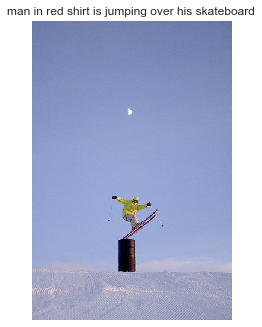

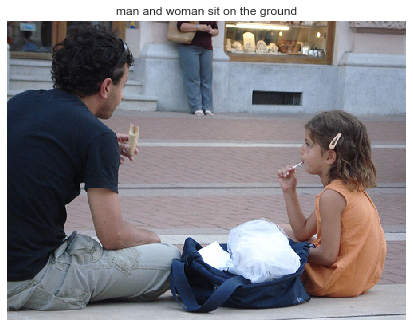

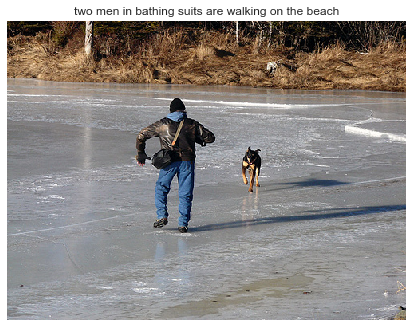

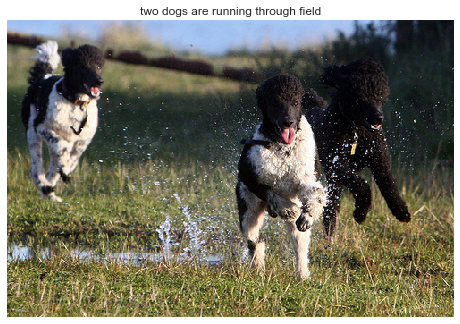

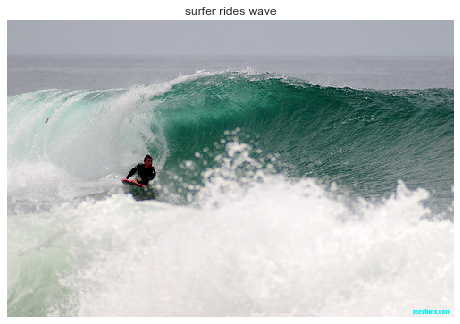

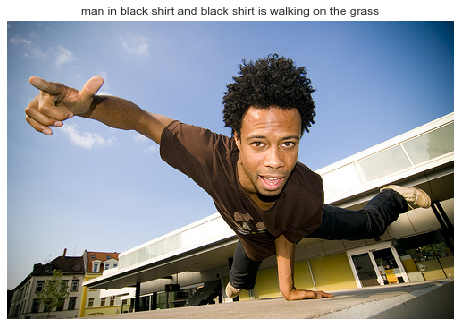

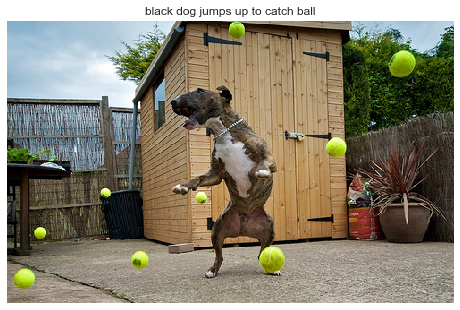

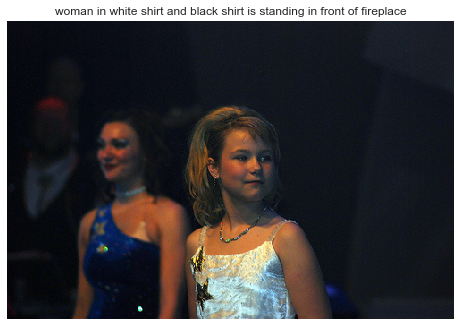

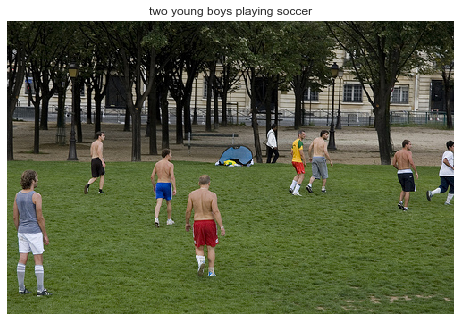

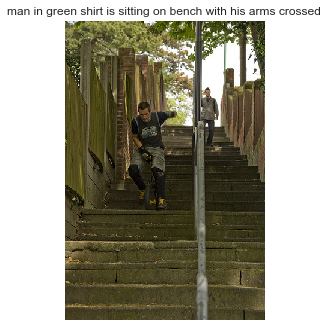

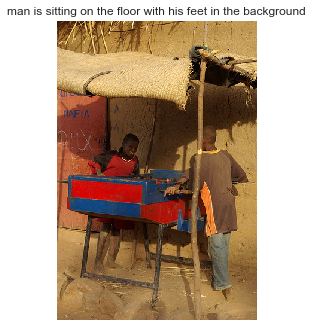

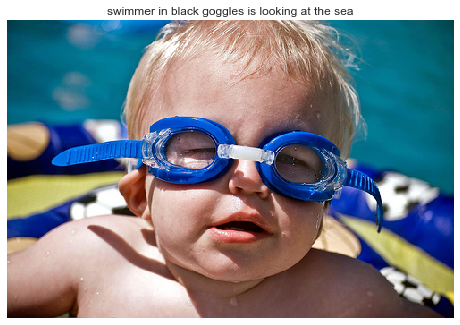

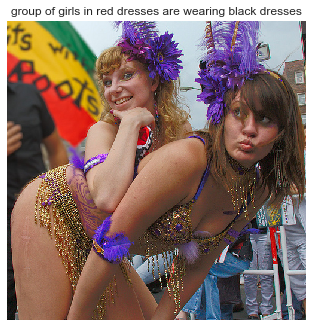

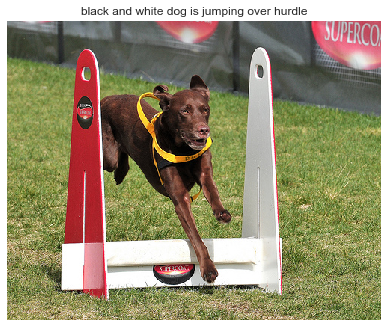

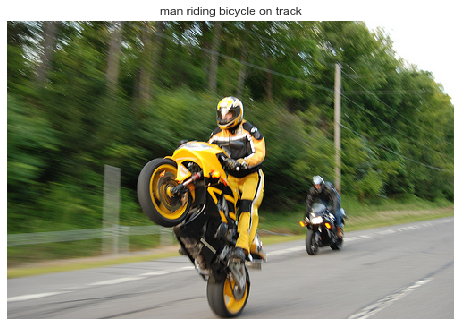

In [115]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./flickr8k/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()